# Streaming

In [4]:
## Create LLM
from langchain_ollama import ChatOllama

llm = ChatOllama(model="deepseek-r1:1.5b", temperature=0)

In [5]:
## Create memory for LLM
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

In [6]:
## Create State
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list, add_messages]

## Create Node
def superbot(state:State):
    return {"messages": [llm.invoke(state["messages"])]}

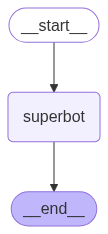

In [4]:
## Create the Graph
from langgraph.graph import StateGraph, START, END

graph_builder=StateGraph(State)

## Adding Node
graph_builder.add_node("superbot",superbot)

## Adding Edges
graph_builder.add_edge(START, "superbot")
graph_builder.add_edge("superbot", END)

## Compile the graph
graph=graph_builder.compile(checkpointer=memory)
graph

In [ ]:
## Create a Thread
config={"configurable":{"thread_id":"101"}}

## Invoke the graph 
for chunk in graph.stream({"messages":"Hi, My name is Rahul and I love to play cricket"},config=config,stream_mode="updates"):
    print(chunk)

In [ ]:
## Invoke the graph 
for chunk in graph.stream({"messages":"I also love play batminton"},config=config,stream_mode="values"):
    print(chunk)

In [ ]:
## Create a Thread
config={"configurable":{"thread_id":"2649"}}

## Invoke the graph 
async for chunk in graph.astream_events({"messages":"Hi, My name is Rahul and I love to play cricket"},config=config,version="v2"):
    print(chunk)

## Human Feedback in the Loop

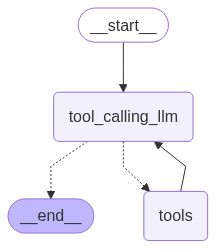

In [7]:
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from langgraph.types import Command, interrupt

## Create graph builder
graph_builder=StateGraph(State)

## Human Assistance Tool
@tool
def human_assistance(query:str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({ "query": query })
    return human_response["data"]


## Multiply Tool
@tool
def multiply(a:int,b:int) -> int:
    """
    Multiple two numbers
    
    a: first int
    b: second int

    Retruns:
        int result of multiplication
    """
    return a*b

tools = [multiply, human_assistance]
llm_with_tools = llm.bind_tools(tools)

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph
builder=StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_conditional_edges("tool_calling_llm", tools_condition)

builder.add_edge("tools", "tool_calling_llm")
builder.add_edge(START, "tool_calling_llm")

graph = builder.compile(checkpointer=memory)
graph

In [8]:
user_input = "I need some expert assistance for my multiplication of 525 by 25?"
config={"configurable":{"thread_id":"1"}}

events = graph.stream({"messages":user_input},
                      config,
                      stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert assistance for my multiplication of 525 by 25?


ResponseError: registry.ollama.ai/library/deepseek-r1:1.5b does not support tools (status code: 400)